In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# **Load the training data**

We load the training data.

In [2]:
import datetime
from implementations import *

data_load = load_data("x_train.csv")
pred = load_data("y_train.csv")
print(f"The data has {data_load.shape[0]} samples and {data_load.shape[1]} features !")

The data has 328135 samples and 321 features !


We clean the data by removing the nan values by the mean of the rest of the feature

In [3]:
data = np.ones(data_load.shape)
stds = np.array([])
for i in range(data.shape[1]):
    d, std = standardize_clean(data_load[:, i])
    data[:, i] = d
    stds = np.append(stds, std)
print(stds.shape)

(321,)


We further clean the data by removing the features where the variance is zero since they are constants for all samples

In [4]:
indices = np.where(stds != 0)
data_var = data[:, indices]
data_var = np.squeeze(data_var, axis = 1)
print(data_var.shape)

(328135, 315)


We also remove the 8 first features as the appear weird in the task of predicting a heart attack

In [5]:
data_cleaned = data_var[:, 9:]
print(data_cleaned.shape)

(328135, 306)


We then separe the data to train on 60% of the total and to test it on the remaining 40% 

In [47]:
train_size = np.floor(data_cleaned.shape[0] * 0.6).astype(int)
data_cross = data_cleaned[:train_size, :]
pred_cross = pred[:train_size]
data_test = data_cleaned[train_size:, :]
pred_test = pred[train_size:]
print(f"Cross shape : {data_cross.shape} ; Test shape : {data_test.shape}")

Cross shape : (196881, 306) ; Test shape : (131254, 306)


Now we build our models for linear regression

In [48]:
y, tx = build_model_data(data_cross, pred_cross)
y_test, tx_test = build_model_data(data_test, pred_test)
print(f"The data has now {tx.shape[1]} features !")

The data has now 307 features !


## Linear regression using gradient descent

Here we train our model using GD with MSE

In [38]:
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 0.09

start_time = datetime.datetime.now()
w, loss = mean_squared_error_gd(y, tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 16.369152 seconds


# Logistic gradient descent

In [39]:
start_time = datetime.datetime.now()
w, loss = logistic_gradient_descent(y, tx, initial_w, gamma=gamma,max_iters=max_iters)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 11.295517 seconds


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

In [55]:
pred_data = np.dot(tx, w)
pred_data = (pred_data > 0.49).astype(float)
correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == 0))

tn = np.sum((pred_data == 0) & (y == 0))
fn = np.sum((pred_data == 0) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"True positive rate: {tp/(tp + fp)*100}%")
print(f"True negative rate: {tn/(tn + fn)*100}%")
print(w)

Accuracy: 91.27188504731284%
True positive rate: 54.06427221172023%
True negative rate: 91.37212760756192%
[-3.66218315e-01  6.72298472e-04  6.90413823e-04 -8.42881041e-06
 -3.71291650e-03  1.08350246e-03 -6.88026430e-03 -5.36582420e-03
 -9.70325242e-04 -8.08297675e-04 -6.60713404e-04 -3.63713197e-04
  4.22154400e-02 -1.64325748e-02 -2.27808670e-03 -4.77903794e-03
 -3.38872435e-03 -2.15647336e-03 -2.62364995e-03 -5.97217036e-03
 -3.10990629e-02 -7.91702576e-03 -5.47454065e-03 -1.01307279e-02
 -1.97834564e-02 -2.09681555e-02 -4.69179538e-03 -7.08114501e-04
 -8.12309830e-03 -8.16833912e-03 -1.43809033e-02 -1.37126679e-02
 -4.91205122e-03 -9.89491429e-03 -2.73971311e-02  8.71937537e-04
 -1.86831734e-02 -3.91166169e-03 -1.04842414e-02  1.75637187e-04
  8.54978650e-04  1.67994949e-04  3.79329030e-03 -1.59059424e-02
  2.86210219e-02  1.04616696e-02 -7.12712497e-04  1.60460927e-02
 -4.44613186e-03 -6.03653872e-04  6.22288667e-04 -1.55312456e-02
 -1.95964126e-02 -6.18420727e-03 -4.54964911e-03

Now we compute some metrics for our test data (40% of the total data)

In [51]:
pred_test = np.dot(tx_test, w)
pred_test = (pred_test > 0.49).astype(float)
correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == 0))

tn = np.sum((pred_test == 0) & (y_test == 0))
fn = np.sum((pred_test == 0) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"True positive rate: {tp/(tp + fp)*100}%")
print(f"True negative rate: {tn/(tn + fn)*100}%")

ValueError: shapes (131254,307) and (308,) not aligned: 307 (dim 1) != 308 (dim 0)

In [42]:
#filter removing small weights
#selecting the weights
indices_to_keep = np.where(np.abs(w) > 0.01)[0]
weights_filtered = w[indices_to_keep]

#removing columns with small weights
data_cross_2 = data_cross[:,indices_to_keep]

#Build model again
y, tx = build_model_data(data_cross_2, pred_cross)
data_test_2 = data_test[:,indices_to_keep]
y_test, tx_test = build_model_data(data_test_2, pred_test)
print(f"The data has now {tx.shape[1]} features !")

#retest log
initial_w = np.zeros(tx.shape[1])
start_time = datetime.datetime.now()
w, loss = logistic_gradient_descent(y, tx, initial_w, gamma=gamma,max_iters=max_iters)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

#Metrics
pred_test = np.dot(tx_test, w)
pred_test = (pred_test > 0.49).astype(float)
correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == 0))

tn = np.sum((pred_test == 0) & (y_test == 0))
fn = np.sum((pred_test == 0) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"True positive rate: {tp/(tp + fp)*100}%")
print(f"True negative rate: {tn/(tn + fn)*100}%")

The data has now 52 features !
Execution time 2.712544 seconds
Accuracy: 99.97409602754963%
True positive rate: 0.0%
True negative rate: 99.98095165530115%


In [53]:
from implementations import regd_logistic_regression
start_time = datetime.datetime.now()
w = regd_logistic_regression(tx, y,num_iter=100,fit_intercept=False)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")


Execution time 10.966218 seconds


### Feature analysis

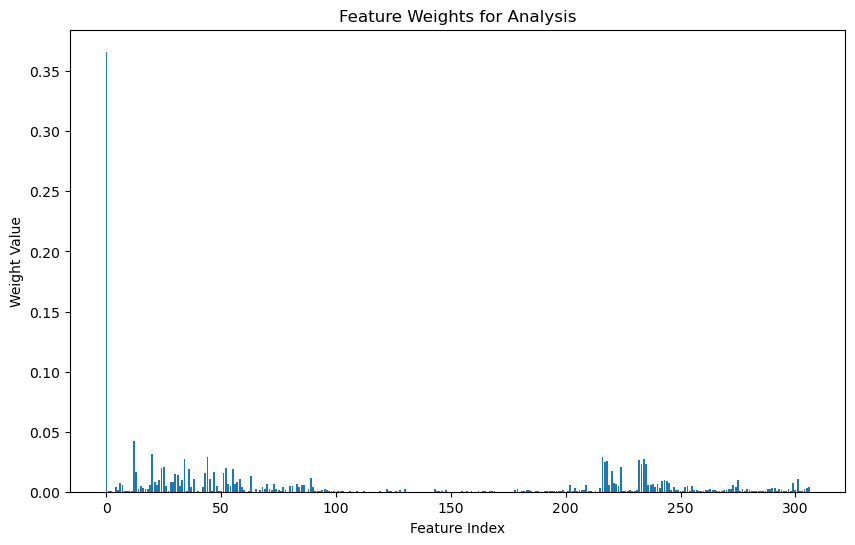

In [54]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(w)), np.abs(w))
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

# **Load the testing data**

In [17]:
test_data, test_pred, test_ids = load_data("test.csv")
for i in range(test_data.shape[1]):
    test_data[:, i] = standardize(test_data[:, i])[0]
test_y, test_tx = build_model_data(test_data, test_pred)

FileNotFoundError: ../data/test.csv not found.

### Predict the label with our trained model

In [112]:
test_y = np.dot(test_tx, w)
test_y = (test_y > 0.5).astype(float)